# Earthquake Prediction
In this kernel I will explore the data and try to use some different models to predict the time of the "earthquake". This is my first kernel so any feedback is appreciated!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

['lanl-lstm-dataset', 'LANL-Earthquake-Prediction']


# 1) Load the Data

In [2]:
%%time
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 19s, sys: 12.4 s, total: 2min 31s
Wall time: 2min 32s


In [3]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


# 2) Visualize the Data
I like to start by looking at the data, which in this case is a pretty simple time series.

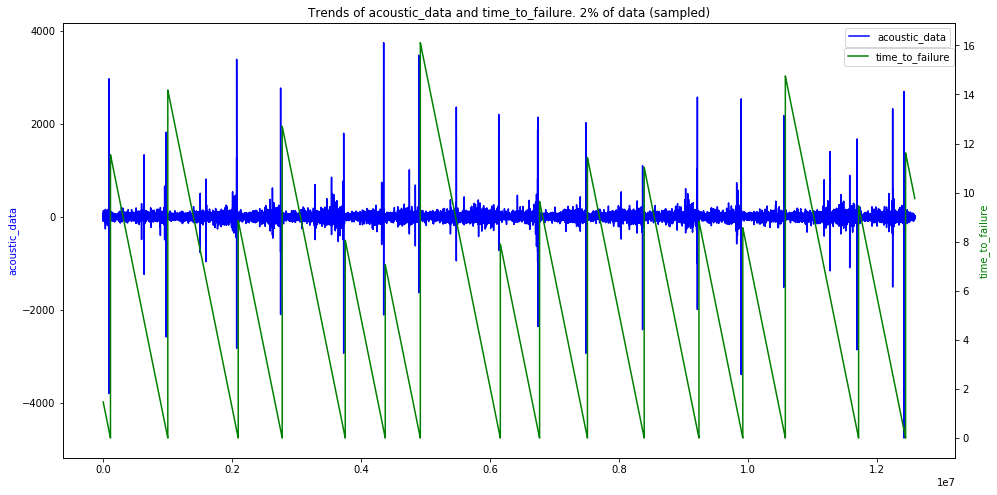

In [4]:
%matplotlib inline

train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

# 3) Generate the features
Here I will calculate some features from a moving window similar to https://doi.org/10.1002/2017GL074677

Features: Mean, variance, skewness, kurtosis (normalized and not)

BEWARE OF LARGE DATA! You can't load the entire dataset into memory at once (At least I couldn't on my laptop).

<a href="http://tinypic.com?ref=vcut1j" target="_blank"><img src="http://i66.tinypic.com/vcut1j.jpg" border="0"></a>

In [5]:
%%time
feat_mat = np.zeros((15000,23))
fs = 4000000 # Hz
window_time = 0.0375 # seconds
offset = 0.01 # seconds
window_size = int(window_time*fs)

for i in np.arange(0,feat_mat.shape[0]):
    start = int(i*offset*fs)
    stop = int(window_size+i*offset*fs)
    seg = train.iloc[start:stop,0]

    feat_mat[i,0] = np.mean(seg)
    feat_mat[i,1] = np.var(seg)
    feat_mat[i,2] = scipy.stats.skew(seg)
    feat_mat[i,3] = scipy.stats.kurtosis(seg)
    feat_mat[i,-1] = train.iloc[stop,1]
    

CPU times: user 1min 13s, sys: 8 ms, total: 1min 13s
Wall time: 1min 13s


Next, we will calculate percentiles and add the time the signal spends above those "thresholds" as a feature. This is intuitive because you can see from the data, as the earthquake comes closer, the signal goes through bouts of higher magnitude. That is, the time the signal spends in the 91st percentile, for example, should go up as time_to_failure goes down. In the paper cited above, they calculate features based on the time spent above a certain threshold (1st to 9th and 91st to 99th).

In [6]:
lower_perc = np.percentile(train.iloc[:,0],np.arange(1,10))
upper_perc = np.percentile(train.iloc[:,0],np.arange(91,100))

for i in np.arange(0,feat_mat.shape[0]):
    start = int(i*offset*fs)
    stop = int(window_size+i*offset*fs)
    seg = train.iloc[start:stop,0]
    
    for j in np.arange(0,lower_perc.shape[0]):
        perc = np.size(np.where(seg>lower_perc[j])[0])
        feat_mat[i,4+j] = perc/seg.shape[0] 
        
    for j in np.arange(0,upper_perc.shape[0]):
        perc = np.size(np.where(seg>upper_perc[j])[0])
        feat_mat[i,13+j] = perc/seg.shape[0] 

    

In [7]:
df = pd.DataFrame(feat_mat,columns=['mean', 'var', 'skew', 'kurt','perc1','perc2','perc3','perc4','perc5','perc6','perc7','perc8','perc9','perc91','perc92','perc93','perc94','perc95','perc96','perc97','perc98','perc99','time_to_failure'],dtype=np.float64)

In [8]:
df.head()

,mean,var,skew,kurt,perc1,perc2,perc3,perc4,perc5,perc6,perc7,perc8,perc9,perc91,perc92,perc93,perc94,perc95,perc96,perc97,perc98,perc99,time_to_failure
0,4.884113,26.021110,-0.024061,33.661319,0.993160,0.983327,0.972660,0.962893,0.947013,0.922867,0.922867,0.922867,0.884593,0.105367,0.071327,0.071327,0.049573,0.049573,0.035567,0.026733,0.016673,0.006933,1.430797
1,4.792853,29.356730,0.396437,103.267636,0.992987,0.982847,0.971840,0.962220,0.946300,0.922193,0.922193,0.922193,0.883427,0.097907,0.065753,0.065753,0.045547,0.045547,0.032853,0.024880,0.015607,0.006920,1.420198
2,4.730867,38.116754,0.531294,116.757047,0.991600,0.980613,0.968740,0.957947,0.941373,0.916060,0.916060,0.916060,0.875953,0.099907,0.068220,0.068220,0.047907,0.047907,0.035013,0.026893,0.017120,0.007887,1.409599
3,4.672107,39.427766,0.522032,109.758838,0.990887,0.979173,0.966607,0.955413,0.938573,0.912353,0.912353,0.912353,0.871813,0.098873,0.068760,0.068760,0.048893,0.048893,0.036173,0.028147,0.018373,0.008553,1.399996
4,4.719380,47.123032,0.348305,88.241359,0.988220,0.974980,0.961660,0.950373,0.933527,0.907420,0.907420,0.907420,0.867973,0.106913,0.075467,0.075467,0.054980,0.054980,0.041420,0.032753,0.022153,0.011180,1.389297


# 4) Apply models

In [9]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, LassoCV, LassoLarsCV
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [10]:
dataset = df.values

X_train, X_test, y_train, y_test = train_test_split(dataset[:,:-1],dataset[:,-1],test_size=0.2)

## 4a) Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

print("MAE = ",mean_absolute_error(y_test,pred_lr))

MAE =  2.127561284485727


## 4b) Random Forest

Primer on Random Forest:

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [12]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print("MAE = ",mean_absolute_error(y_test,pred_rf))

MAE =  2.049052494604521


## 4c) Neural Network
See https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [13]:
NN = MLPRegressor()
NN.fit(scale(X_train),y_train)

pred_nn = NN.predict(scale(X_test))

print("MAE = ", mean_absolute_error(y_test,pred_nn))

MAE =  2.0775148783549473


## 4d) Ensemble methods

### 4di) Bagging
Make a bunch of models and give them to the BaggingRegressor to see if it improves the score.

In [14]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
lcv = LassoCV()
llcv = LassoLarsCV()
lr = LinearRegression()
NN = MLPRegressor()

# Put as many of the models as you want in this list
clf_array = [rf,NN,lcv,llcv,lr]

In [15]:
for clf in clf_array:
    clf.fit(scale(X_train),y_train)
    pred = clf.predict(scale(X_test))
    vanilla_scores = mean_absolute_error(y_test,pred)
    
    bagging_clf = BaggingRegressor(clf, max_samples=0.25, max_features=1.0, random_state=27)
    bagging_clf.fit(scale(X_train),y_train)
    pred_bag = bagging_clf.predict(scale(X_test))
    bag_scores = mean_absolute_error(y_test,pred_bag)
    
    print("vanilla {}: {}",clf,vanilla_scores)
    print("bagging {}: {}",clf,bag_scores)

    

vanilla {}: {} RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 2.054723610614454
bagging {}: {} RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 2.077799701599944


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

vanilla {}: {} MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 2.06480798905843
bagging {}: {} MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 2.077890001743413


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

vanilla {}: {} LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False) 2.1331388947207053
bagging {}: {} LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False) 2.131284373223639


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.014e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.014e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.161e-02, with an active set of 2 regressors, and the smallest cholesky pivot element

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.484e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.491e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.056e-03, with an active set of 8 regressors, and the smallest cholesky pivot element be

vanilla {}: {} LassoLarsCV(copy_X=True, cv='warn', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=None,
      normalize=True, positive=False, precompute='auto', verbose=False) 2.256867258583921
bagging {}: {} LassoLarsCV(copy_X=True, cv='warn', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=None,
      normalize=True, positive=False, precompute='auto', verbose=False) 3.194999983988803
vanilla {}: {} LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False) 2.1303775248618035
bagging {}: {} LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False) 2.131023100503804


# Load the test data and make predictions

In [16]:
from tqdm import tqdm_notebook

submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

X_test = pd.DataFrame(columns=df.columns, dtype=np.float64, index=submission.index)

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/LANL-Earthquake-Prediction/test/' + seg_id + '.csv')
    X_test.loc[seg_id, 'mean'] = np.mean(seg.values)
    X_test.loc[seg_id, 'var'] = np.var(seg.values)
    X_test.loc[seg_id, 'skew'] = scipy.stats.skew(seg.values)
    X_test.loc[seg_id, 'kurt'] = scipy.stats.kurtosis(seg.values)
    
    for j in np.arange(0,9):
        perc = np.size(np.where(seg>lower_perc[j])[0])
        X_test.loc[seg_id, 'perc{}'.format(j+1)] = perc/seg.shape[0] 
        
        perc = np.size(np.where(seg>upper_perc[j])[0])
        X_test.loc[seg_id, 'perc9{}'.format(j+1)] = perc/seg.shape[0]

    

In [17]:
X_test.drop(columns=['time_to_failure'],inplace=True)
X_test.head()

,mean,var,skew,kurt,perc1,perc2,perc3,perc4,perc5,perc6,perc7,perc8,perc9,perc91,perc92,perc93,perc94,perc95,perc96,perc97,perc98,perc99
seg_id,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,23.948039,0.327904,28.836567,0.993013,0.982353,0.970080,0.958527,0.939587,0.910520,0.910520,0.910520,0.864727,0.090780,0.061067,0.061067,0.042380,0.042380,0.030467,0.022667,0.014080,0.006227
seg_0012b5,4.171153,35.079793,0.295705,56.217041,0.988540,0.976560,0.963193,0.950827,0.930460,0.898353,0.898353,0.898353,0.848600,0.079640,0.055840,0.055840,0.040540,0.040540,0.030960,0.025073,0.017787,0.009287
seg_00184e,4.610260,48.260349,0.428684,162.112840,0.989680,0.979633,0.969647,0.960153,0.944887,0.919407,0.919407,0.919407,0.879120,0.089073,0.060247,0.060247,0.042600,0.042600,0.032040,0.025053,0.017587,0.009667
seg_003339,4.531473,16.926089,0.061889,41.240413,0.995713,0.990387,0.984793,0.978853,0.967093,0.944680,0.944680,0.944680,0.905640,0.056433,0.033640,0.033640,0.021240,0.021240,0.014827,0.011340,0.007700,0.003720
seg_0042cc,4.128340,33.606882,0.073898,79.537016,0.990227,0.978287,0.965847,0.954340,0.934720,0.903413,0.903413,0.903413,0.854360,0.071340,0.049540,0.049540,0.035853,0.035853,0.027953,0.022607,0.015993,0.008233


In [18]:
# Pick any model to make predictions and place it where "rf" is currently.

rf.fit(scale(dataset[:,:-1]),dataset[:,-1])

predictions = rf.predict(scale(X_test))

submission['time_to_failure'] = predictions
submission.to_csv('submission.csv')